# Video Mining/Emotion Detection Example 




**Explanation of choice for features, plan for tackling the dimensionality (ca. 350 words)**

We have a subsets of movie trailers from 1920-1940, 1960-1980 and
2000-2020 .I am going to analyse the emotions of each subsets using image feature extraction methods since I expect the emotions to have increased over the years as Hollywood movies have become increasingly spectucular and dramatic from my individual perspective in terms of action as well as emotions. People have more choice, so if they a movie that does not grab their attention fast enough,they can simply switch the channel or move their attention to their smartphone. So that is why emotions could be more important than "long "neutral dialogs that i remember from old black and white movies. 

To be more precise if this development was true that would mean that emotions like anger ,disgust,fear,happiness,sadness,surprise
increase for each subset  over the years whereas the emotion 'neutral' would decrease.  These are the emotions our model can detect in a face.

We are going to tackle the dimensionality by comparing 5 random trailers of all three subsets and by counting the number of every emotion for each subset.  This is done by a model that first recognizes the faces and then the emotions of these. Because the lenght of the videos might have increased over time. Thr main approach would be to only could the number of each emotion type per subset. But we have to account for the fact that the length of the trailers in each of the subset might be different. This could for instance results in more frames and in turn in more total emotions. 

Therfore, we first determine the number of scenes, total frames, and frames per second that we use, so that we can later isolate these factors by dividing the number each emotions per subsets by these. 

Lastly, we will control if our models funcitioned properly by manually looking at a random number of shots and checking if that frame matches the emotion detected by our model.




In [ ]:
#We install and import the necessary packages

!pip install wget 
!pip install --upgrade tensorflow
!pip install scenedetect
!pip install cv2

import cv2 #to get the frames
from tqdm import tqdm_notebook
import wget  #to get the models
import tensorflow as tf # to load the models
from tensorflow import keras #to load the models
from keras.models import load_model #also for modelling purposes
import pandas as pd #to work with our dataframes
import numpy as np  #for array computing
import matplotlib.pyplot as plt #to display a picture single frame
from tqdm.notebook import tqdm #to show progress of the model
import os #interacting with the operating system
import scenedetect #o detect the number of shots
from scenedetect import VideoManager #to detect the number of scenes
from scenedetect import SceneManager #to detect the number of scenes
from scenedetect.detectors import ContentDetector #to detect the number of scenes



Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages (2.4.0)
ERROR: Could not find a version that satisfies the requirement cv2 (from versions: none)
ERROR: No matching distribution found for cv2


In [ ]:
 #we load in the dataframe where the data on the trailer as well theirs paths can be found.

 df = pd.read_csv("/content/trailers.csv")

In [ ]:
#We split the dataset into three subset from exercise 6.1 and take 5 random samples from each sample

n = 5
trailers1920 = df[(df.year > 1920) & (df.year < 1940)].sample(n)
trailers1960 = df[(df.year > 1960) & (df.year < 1980)].sample(n)
trailers2000 = df[df.year > 2000].sample(n)

In [ ]:
#For each subset, we download the videos in the subset using with the provided URLs. 



In [ ]:
#This code is to iterate through the table along the video download links and create folders to save the videos

def dl_sample(df, folder):
    if not os.path.exists(folder):
        os.mkdir(folder)
    
    video_paths = []
    for video in df.itertuples():
        video_url = video.url
        output_path = folder + video.trailer_title + '.mp4'
        filename = wget.download(video_url, out=output_path)
        video_paths.append(output_path)
        
    return video_paths

In [ ]:
#this code downloads the trailers in three different folders fo each subset.

trailer1920 = dl_sample(trailers1920, 'vid_1920/')
trailer1960 = dl_sample(trailers1960, 'vid_1960/')
trailer2000 = dl_sample(trailers2000, 'vid_2000/')

In [ ]:
print(trailer1920)

['vid_1920/TOP HAT trailer.mp4', "vid_1920/OTHER MEN'S WOMEN trailer.mp4", 'vid_1920/FIVE STAR FINAL trailer.mp4', 'vid_1920/DINNER AT EIGHT trailer.mp4', 'vid_1920/THE BRIDE OF FRANKENSTEIN 1935 trailer.mp4']


In [ ]:
#First we determine the number of scenes if want to control for that later

In [ ]:
#we use the function from the manual

def find_scenes(video_path, threshold=30.0):
    video_manager = VideoManager([video_path])
    scene_manager = SceneManager()
    scene_manager.add_detector(
        ContentDetector(threshold=threshold))
    base_timecode = video_manager.get_base_timecode()
    video_manager.set_downscale_factor()
    video_manager.start()
    scene_manager.detect_scenes(frame_source=video_manager, show_progress=False)    
    return scene_manager.get_scene_list(base_timecode)

In [ ]:
#First we create a df that countains the paths to the videos, a column for the subset (period) name and a column for the total frames count as well
# as the number frames when getting oen frame per second. 

list_complete = trailer1920 + trailer1960 + trailer2000

df_scenes = pd.DataFrame(list_complete, columns = ['paths'])

df_scenes['period'] = ['20_40']*5 + ['60_80']*5 + ['00_20']*5 
df_scenes['sceneCount'] = None
df_scenes['frames'] = None
df_scenes['frameCount'] = None

#We iterate through the video paths to get the n of scenes, total frames, and frames per second and the actual frames

for i in range(len(df_scenes.paths)):
  # scene count
  scene_list = find_scenes(df_scenes.paths[i], threshold=30)
  df_scenes['sceneCount'][i] = len(scene_list)

  # frame count
  cap = cv2.VideoCapture(df_scenes.paths[i])
  df_scenes['frameCount'][i] = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) # total number of frames

  # one frame per sec
  TOTAL_FRAMES = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
  FRAME_RATE = round(cap.get(5)) 
  selected_frames = np.cumsum([FRAME_RATE for i in range(int(TOTAL_FRAMES / FRAME_RATE)) ])
 
#this code gets the actual frames 

  df_scenes['frames'][i] = []
  for frame in tqdm_notebook(selected_frames):
      cap.set(cv2.CAP_PROP_POS_FRAMES,frame)
      ret, frame = cap.read()
      frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
      df_scenes['frames'][i].append(frame) # add it to the list

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [ ]:
#To our existing df we add a column where we at another column for the number of frames per second (Used frames)

df_scenes['usedFrames'] = None
for i in range(len(df_scenes.paths)):
  df_scenes['usedFrames'][i] =   len(df_scenes.frames[i])

In [ ]:
#We make an aggrregate dataframe to get the total number of scenes, total frames, total frames with one frame per second (used frames) grouped by each time subset. 

dfsceneagg = df_scenes.groupby(['period'])['sceneCount', 'frameCount', 'usedFrames'].agg('sum').reindex(['20_40', '60_80', '00_20'])
dfsceneagg


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


,sceneCount,frameCount,usedFrames
period,,,
20_40,44,18472,613
60_80,199,18497,614
00_20,372,19059,632


In [ ]:
#we save photos as jpg

from pathlib import Path
for k in df_scenes.paths:
  Path("/content/frames/"+ k.replace('.mp4', '')).mkdir(parents=True, exist_ok=True)

In [ ]:
for k in range(len(df_scenes.paths)):
  for i, frame in enumerate(df_scenes.frames[k]):
      cv2.imwrite('/content/frames/{path}/frame_{name}.jpg'.format(path=df_scenes.paths[k].replace('.mp4',''),name=i), frame)

In [ ]:
#We define load image_from path 

import io
import urllib

import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from tensorflow.keras.preprocessing import image

%config InlineBackend.figure_format='retina' 

def load_image_from_url(url, target_size=None, color_mode='rgb'):
    assert color_mode in ('grayscale', 'rgb'), 'color_mode must be "grayscale" or "rgb"'
    response = urllib.request.urlopen(url)
    img = Image.open(io.BytesIO(response.read()))
    img = img.convert('RGB')
    if color_mode == 'grayscale':
        img = ImageOps.grayscale(img)
    if target_size:
        img = img.resize(target_size, Image.NEAREST) # resize
    return image.img_to_array(img)

def load_image_from_path(image_path, target_size=None, color_mode='rgb'):
    pil_image = image.load_img(image_path, 
                               target_size=target_size,
                            color_mode=color_mode)
    return image.img_to_array(pil_image)

In [ ]:
#We define the pathes of each subset

from os import listdir, walk
from os.path import isfile, join


mypath1 = '/content/frames/vid_1920'
paths_1 = [join(mypath1,f) for mypath1,dirs,files in walk(mypath1) for f in files]

mypath2 = '/content/frames/vid_1960'
paths_2 = [join(mypath2,f) for mypath2,dirs,files in walk(mypath2) for f in files]

mypath3 = '/content/frames/vid_2000'
paths_3 = [join(mypath3,f) for mypath3,dirs,files in walk(mypath3) for f in files]

In [ ]:
# First we try only face detection for the frames of only one movie to see if it works

#!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
!pip install wget
import wget
model_url = 'https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml'
face_model = wget.download(model_url)

# we make a list for the faces of each subset

faces_list_1 = []
faces_list_2 = []
faces_list_3 = []

#we get the faces for each subset

for i in tqdm(range(0,len(paths_1))):
    pre_image = load_image_from_path(paths_1[i], color_mode='grayscale')
    gray_image = np.squeeze(pre_image).astype('uint8')

    face_classification = cv2.CascadeClassifier(face_model) # load the classifier 
    faces = face_classification.detectMultiScale(gray_image, 1.3, 5) # detect the faces 
    n_faces = len(faces) # get the number of faces
    faces_list_1.append(faces)

for i in tqdm(range(0,len(paths_2))):
    pre_image = load_image_from_path(paths_2[i], color_mode='grayscale')
    gray_image = np.squeeze(pre_image).astype('uint8')

    face_classification = cv2.CascadeClassifier(face_model) # load the classifier 
    faces = face_classification.detectMultiScale(gray_image, 1.3, 5) # detect the faces 
    n_faces = len(faces) # get the number of faces
    faces_list_2.append(faces)

for i in tqdm(range(0,len(paths_3))):
    pre_image = load_image_from_path(paths_3[i], color_mode='grayscale')
    gray_image = np.squeeze(pre_image).astype('uint8')

    face_classification = cv2.CascadeClassifier(face_model) # load the classifier 
    faces = face_classification.detectMultiScale(gray_image, 1.3, 5) # detect the faces 
    n_faces = len(faces) # get the number of faces
    faces_list_3.append(faces)

In [ ]:
def apply_offsets(face_coordinates, offsets):
    """
    Derived from https://github.com/oarriaga/face_classification/blob/
    b861d21b0e76ca5514cdeb5b56a689b7318584f4/src/utils/inference.py#L21
    """
    x, y, width, height = face_coordinates
    x_off, y_off = offsets
    return (x - x_off, x + width + x_off, y - y_off, y + height + y_off)

In [ ]:
#Now we perfom the emotion classifier for all of the three subsets

# !wget https://github.com/oarriaga/face_classification/raw/master/trained_models/emotion_models/fer2013_mini_XCEPTION.102-0.66.hdf5      

emotion_classifier = load_model('fer2013_mini_XCEPTION.102-0.66.hdf5') # load this only once! (not in a loop)

EMOTION_OFFSETS = (0, 0)
INPUT_SHAPE_EMOTION = emotion_classifier.input_shape[1:3]

label_count_first_set = {}

labels = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
# go through all the faces in the first set (1920s)
for faces in faces_list_1:
  # process all coordinates for each face
  for face_coordinates in faces:
      x1, x2, y1, y2 = apply_offsets(face_coordinates, EMOTION_OFFSETS) 
      face_img = gray_image[y1:y2, x1:x2] # only get the face
      # catch the src.empty() error cv throws
      try:
        face_img = cv2.resize(face_img, (INPUT_SHAPE_EMOTION))
      except:
        continue
      face_img = face_img.astype('float32') / 255.0 # pre-processing 
      face_img = face_img - 0.5 # pre-processing specific to the emotion classifier
      face_img = face_img * 2.0 # pre-processing specific to the emotion classifier
      face_img = np.expand_dims(face_img, 0) # batch of one
      face_img = np.expand_dims(face_img, -1) # pre-processing specific to the emotion classifier
      probas = emotion_classifier.predict(face_img)
      label = labels[np.argmax(probas[0])]
      temp_emotionprobas = dict(zip(labels, probas[0])) # make a dictionary from the labels and the probabilities
      # we try increase the count for the label
      try:
        label_count_first_set[label] += 1
      # but the first time we try, the key is not present, so we just give it value of 1
      except KeyError:
        label_count_first_set[label] = 1
print(label_count_first_set)

{'angry': 176, 'fear': 4, 'neutral': 27, 'sad': 2, 'surprise': 1}


In [ ]:
#we repeat the same process for the second subset

label_count_second_set = {}

labels = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
for faces in faces_list_2:
  for face_coordinates in faces:
      x1, x2, y1, y2 = apply_offsets(face_coordinates, EMOTION_OFFSETS) 
      face_img = gray_image[y1:y2, x1:x2] # only get the face
      try:
        face_img = cv2.resize(face_img, (INPUT_SHAPE_EMOTION))
      except:
        continue
      face_img = face_img.astype('float32') / 255.0 # pre-processing 
      face_img = face_img - 0.5 # pre-processing specific to the emotion classifier
      face_img = face_img * 2.0 # pre-processing specific to the emotion classifier
      face_img = np.expand_dims(face_img, 0) # batch of one
      face_img = np.expand_dims(face_img, -1) # pre-processing specific to the emotion classifier
      probas = emotion_classifier.predict(face_img)
      label = labels[np.argmax(probas[0])]
      temp_emotionprobas = dict(zip(labels, probas[0])) # make a dictionary from the labels and the probabilities
      try:
        label_count_second_set[label] += 1
      except KeyError:
        label_count_second_set[label] = 1
print(label_count_second_set)

{'angry': 154, 'fear': 4, 'neutral': 41, 'sad': 5, 'happy': 1}


In [ ]:
#we repeat the same process for the third subset

label_count_third_set = {}

labels = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
for faces in faces_list_3:
  for face_coordinates in faces:
      x1, x2, y1, y2 = apply_offsets(face_coordinates, EMOTION_OFFSETS) 
      face_img = gray_image[y1:y2, x1:x2] # only get the face

      try:
        face_img = cv2.resize(face_img, (INPUT_SHAPE_EMOTION))
      except:
        continue
      face_img = face_img.astype('float32') / 255.0 # pre-processing 
      face_img = face_img - 0.5 # pre-processing specific to the emotion classifier
      face_img = face_img * 2.0 # pre-processing specific to the emotion classifier
      face_img = np.expand_dims(face_img, 0) # batch of one
      face_img = np.expand_dims(face_img, -1) # pre-processing specific to the emotion classifier
      probas = emotion_classifier.predict(face_img)
      label = labels[np.argmax(probas[0])]
      temp_emotionprobas = dict(zip(labels, probas[0])) # make a dictionary from the labels and the probabilities
      # print('This person looks {}'.format(label))
      #for emotion, proba in temp_emotionprobas.items(): # ('angry', 0.1)
        #try:
          #emotionprobas[emotion] += proba
        #except KeyError:
          #emotionprobas[emotion] = proba
      try:
        label_count_third_set[label] += 1
      except KeyError:
        label_count_third_set[label] = 1
print(label_count_third_set)

{'neutral': 44, 'angry': 137, 'fear': 3, 'sad': 6}


In [ ]:
#due to time constraints i quickly manually add the dictionaries to the dfsceneagg in excel

dfsceneagg.to_csv('dfsceneagg.csv')

In [ ]:
#load the edited df 

dfsceneaggedit = pd.read_csv("/content/dfsceneaggedit.csv")

dfsceneaggedit 

,period,sceneCount,frameCount,usedFrames,anger,disgust,fear,happy,sad,surprise,neutral
0,20_40,44,18472,613,176,0,4,0,2,1,27
1,60_80,199,18497,614,154,0,4,1,5,0,41
2,00_20,372,19059,632,137,0,3,0,6,0,44


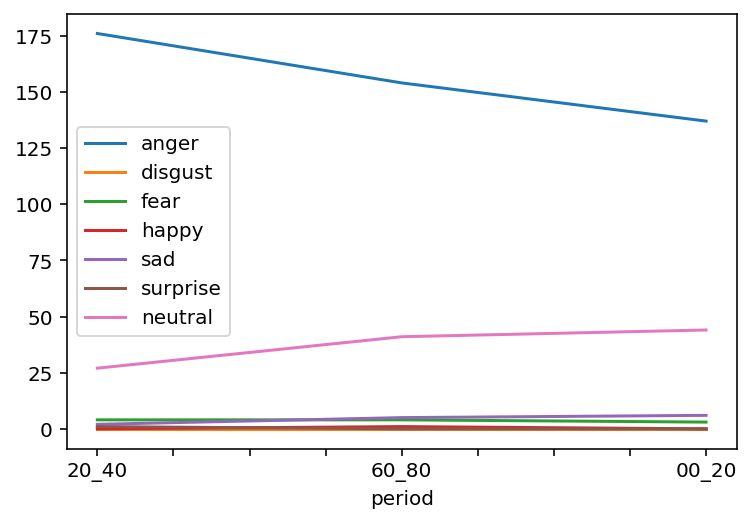

In [ ]:
#  we plot the counts of the emotions over time to see if there is a trend

graph1 = dfsceneaggedit.plot(x='period', y=["anger", "disgust", "fear","happy","sad","surprise","neutral"])
graph1

In [ ]:
#We now divide the two most detected emotions by the number of scenes for each subsets to account for the fact that more scenes could lead to more emotions. 
#and we add to them to the dfsceneaggedit

angerdividescenes= dfsceneaggedit['anger/sceneCount'] = dfsceneaggedit['anger']/dfsceneaggedit['sceneCount']
neutraldividescenes= dfsceneaggedit['neutral/sceneCount'] = dfsceneaggedit['neutral']/dfsceneaggedit['sceneCount']


In [ ]:
dfsceneaggedit

,period,sceneCount,frameCount,usedFrames,anger,disgust,fear,happy,sad,surprise,neutral,anger/sceneCount,neutral/sceneCount
0,20_40,44,18472,613,176,0,4,0,2,1,27,4.000000,0.613636
1,60_80,199,18497,614,154,0,4,1,5,0,41,0.773869,0.206030
2,00_20,372,19059,632,137,0,3,0,6,0,44,0.368280,0.118280


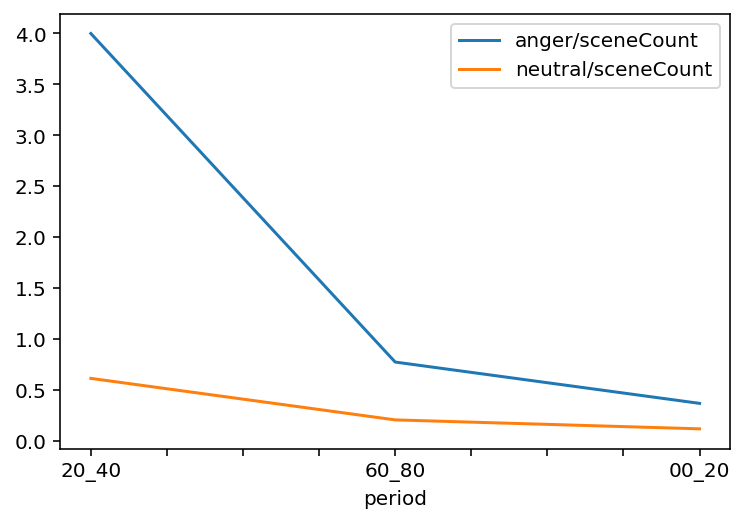

In [ ]:
graph2 = dfsceneaggedit.plot(x='period', y=["anger/sceneCount", "neutral/sceneCount",])
graph2

# Conclusion

The results have to be taken with caution since we only took 5 samples from each time subset and our face detector and emotions classifier might be inaccurate. However, assuming this was not the case we could make the following conclusions. 

Not taking account the number of frames or scenes it is visible (see graph 1 and dfsceneaggedit) that certain emotions occur very seldomly or not all. "Disgust" is not detected at all. "Happiness" and "Surprise" occur only once in only one of the subsets. Although still in low numbers, "fear" falls only by one level throughout the years and "sadness" increases. "Neutral" is detected the second most and increases over the years but only slightly jumping from the 60s and 80s to the years 2000 until 2020. Anger was detected the most and shows a clear downward trend over the years. 

Accounting for the number of scenes this trend is only amplified (see graph 2). Anger goes down down from 4 to 0.36 with an especially sharp decline jumping from 20_40 to 60_80s. The emotion "neutral" actually goes down from 0.6 to 0.11 instead of rising when accounting for the number of scenes. 
We do not account for the number of total frames or used frames since did not change much over the years and that would give us similar insights like graph1. 

We expected "non-neutral" emotions to increase over the years and neutral emotions to decrease over time. When we looked at graph1 where we did not account for scene length and using "anger" as the only non-neutral emotion, the opposite was the case. Accounting for scene length also the neutral emotions would decrease which would match our expections. 

So overall, instead of an increase of non-neutral emotions we found an increase. An explanation could be that in old movies, the acting style was perhaps more theater-like and might today be perceived as "overacted". This is also suggested by this user in Quora (https://qr.ae/pNmoVh).

The results on "Neutral" are more ambigious and I thus adhere from interpreting them. 



